#**Практическое задание №1**

Установка необходимых пакетов:

In [1]:
!pip install -q tqdm
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


Монтирование Вашего Google Drive к текущему окружению:

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Константы, которые пригодятся в коде далее, и ссылки (gdrive идентификаторы) на предоставляемые наборы данных:

In [3]:
EVALUATE_ONLY = False
TEST_ON_LARGE_DATASET = True
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')
DATASETS_LINKS = {
    'train': '1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi',
    'train_small': '1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR',
    'train_tiny': '1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui',
    'test': '1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr',
    'test_small': '1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI',
    'test_tiny': '1viiB0s041CNsAK4itvX8PnYthJ-MDnQc'
}

MY_DATASETS_LINKS = {
    'train': '18bNP8R_k8FYq0Gx0DnC2j_UEOaGqVl14',
    'train_small': '1d-FUmCUvuYyzbMkeD64mT88yW3SBOd6u',
    'train_tiny': '1zdQ4BoKXR-bRU0j0_ja5LeDjl_bPtbGO',
    'test': '14lLsHGRxcTlMkX2Y5j9KxH1W62ZjSiye',
    'test_small': '1Poc6jx3jaHGoYIdAnOIwA7YFgDFuCdEY',
    'test_tiny': '1JcDlKmFQ-ohdFVMQDINGY2EauuSGSVgv', 
    'part1': '1-1FsFFcfx02g8y1FDhKeK2P2Ffs8lERI',
    'part2': '1-BmotDE5HI_DtYvjI2xVO19exkVU_15D',
    'big_part': '1lduzL_qtmIb99cvpZ7GFzJpYTQTIHtr-'
}

Импорт необходимых зависимостей:

In [4]:
from pathlib import Path
import numpy as np
from typing import List
from tqdm.notebook import tqdm
from time import sleep
from PIL import Image
import IPython.display
from sklearn.metrics import balanced_accuracy_score
import gdown
# my
import torch
import torch.nn as nn
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from keras.models import Sequential
from keras.optimizers import Adam
from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from keras.callbacks import Callback

---
### Класс Dataset

Предназначен для работы с наборами данных, обеспечивает чтение изображений и соответствующих меток, а также формирование пакетов (батчей).

In [5]:
class Dataset:

    def __init__(self, name):
        self.name = name
        self.is_loaded = False
        # изменил ссылки на свои
        url = f"https://drive.google.com/uc?export=download&confirm=pbef&id={MY_DATASETS_LINKS[name]}"
        output = f'{name}.npz'
        gdown.download(url, output, quiet=False)
        print(f'Loading dataset {self.name} from npz.')
        np_obj = np.load(f'{name}.npz')
        self.images = np_obj['data']
        self.labels = np_obj['labels']
        self.n_files = self.images.shape[0]
        self.is_loaded = True
        print(f'Done. Dataset {name} consists of {self.n_files} images.')

    def image(self, i):
        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :, :]

    def images_seq(self, n=None):
        # sequential access to images inside dataset (is needed for testing)
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def random_image_with_label(self):
        # get random image with label from dataset
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i]
  
    def random_batch_with_labels(self, n):
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.labels[i] for i in indices])
        return np.stack(imgs), logits

    def image_with_label(self, i: int):
        # return i-th image with label from dataset
        return self.image(i), self.labels[i]

In [6]:
# упрощенный класс Dataset для моих данных, полученных разделением всего train
class Part_Data:
    def __init__(self, name):
        self.name = name
        # изменил ссылки на свои
        url = f"https://drive.google.com/uc?export=download&confirm=pbef&id={MY_DATASETS_LINKS[name]}"
        output = f'{name}.npz'
        gdown.download(url, output, quiet=False)
        print(f'Loading dataset {self.name} from npz.')
        np_obj = np.load(f'{name}.npz')
        self.images = np_obj['x_axis']
        self.labels = np_obj['y_axis']
        print(f'Done. Dataset {name} consists of {len(self.labels)} images.')

### Пример использвания класса Dataset
Загрузим обучающий набор данных, получим произвольное изображение с меткой. После чего визуализируем изображение, выведем метку. В будущем, этот кусок кода можно закомментировать или убрать.

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1zdQ4BoKXR-bRU0j0_ja5LeDjl_bPtbGO
To: /content/train_tiny.npz
100%|██████████| 105M/105M [00:00<00:00, 220MB/s] 


Loading dataset train_tiny from npz.
Done. Dataset train_tiny consists of 900 images.

Got numpy array of shape (224, 224, 3), and label with code 2.
Label code corresponds to DEB class.


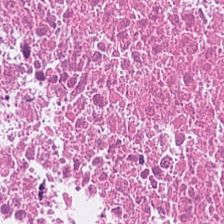

In [ ]:
d_train_tiny = Dataset('train_tiny')

img, lbl = d_train_tiny.random_image_with_label()
print()
print(f'Got numpy array of shape {img.shape}, and label with code {lbl}.')
print(f'Label code corresponds to {TISSUE_CLASSES[lbl]} class.')

pil_img = Image.fromarray(img)
IPython.display.display(pil_img)

---
### Класс Metrics

Реализует метрики точности, используемые для оценивания модели:
1. точность,
2. сбалансированную точность.

In [7]:
class Metrics:

    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt)

    @staticmethod
    def accuracy_balanced(gt: List[int], pred: List[int]):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))

---
### Класс Model

Класс, хранящий в себе всю информацию о модели.

Вам необходимо реализовать методы save, load для сохранения и заргрузки модели. Особенно актуально это будет во время тестирования на дополнительных наборах данных.

> *Пожалуйста, убедитесь, что сохранение и загрузка модели работает корректно. Для этого обучите модель, протестируйте, сохраните ее в файл, перезапустите среду выполнения, загрузите обученную модель из файла, вновь протестируйте ее на тестовой выборке и убедитесь в том, что получаемые метрики совпадают с полученными для тестовой выбрки ранее.*


Также, Вы можете реализовать дополнительные функции, такие как:
1. валидацию модели на части обучающей выборки;
2. использование кроссвалидации;
3. автоматическое сохранение модели при обучении;
4. загрузку модели с какой-то конкретной итерации обучения (если используется итеративное обучение);
5. вывод различных показателей в процессе обучения (например, значение функции потерь на каждой эпохе);
6. построение графиков, визуализирующих процесс обучения (например, график зависимости функции потерь от номера эпохи обучения);
7. автоматическое тестирование на тестовом наборе/наборах данных после каждой эпохи обучения (при использовании итеративного обучения);
8. автоматический выбор гиперпараметров модели во время обучения;
9. сохранение и визуализацию результатов тестирования;
10. Использование аугментации и других способов синтетического расширения набора данных (дополнительным плюсом будет обоснование необходимости и обоснование выбора конкретных типов аугментации)
11. и т.д.

Полный список опций и дополнений приведен в презентации с описанием задания.

При реализации дополнительных функций допускается добавление параметров в существующие методы и добавление новых методов в класс модели.

In [8]:
class Model:

    def __init__(self):
        # использую ResNet50 c предобученными на ImageNet весами, сверху накинул еще несколько слоев
        self.history = None
        self.is_valid = False
        pretrained_model = tf.keras.applications.ResNet50V2(include_top=False,
                        input_shape=(224,224,3), weights = "imagenet")

        self.model = Sequential()
        # добавил слой аугментации данный
        """
        добавил именно такие преобразлования, потому что картинки одной и той же ткани
        очень часто переворачиваются в разных направлениях на разных снимках и 
        получаются в разных масштабах
        """
        #LBL-11 Аугментация данных
        self.model.add(
            keras.Sequential(
                [
                    layers.RandomFlip("horizontal"),
                    layers.RandomFlip("vertical"),
                    layers.RandomRotation(0.3),
                    layers.RandomZoom(0.3),
                ]
            )
        )
        # нормализую норализацию данных для resnet
        self.model.add(tf.keras.layers.Lambda(tf.keras.applications.resnet_v2.preprocess_input, input_shape=(224, 224, 3)))
        self.model.add(pretrained_model)
        self.model.add(tf.keras.layers.Dropout(.2))
        self.model.add(Flatten())
        self.model.add(Dense(256, activation='relu'))
        self.model.add(tf.keras.layers.Dropout(.2))
        self.model.add(Dense(9, activation='softmax'))
        self.model.build(input_shape = (None, 224, 224, 3))
        self.model.compile(optimizer=Adam(learning_rate=0.001),
                             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                             metrics=['accuracy'])

    def save(self, name: str):
        # сохраняю только веса модели
        print(f'Saving {name} is started.')
        self.model.save_weights(f'/content/drive/MyDrive/dev/prac_nn_1/weights_v2_{name}.h5')
        print(f'Save {name} done.')
    
    def load(self, name: str):
        # веса, полученные при обучении на 0.75 части train,
        # полученного, с помощью train_test_split
        name_to_id_dict = {
            '95_acc': '1hB8Uy89FwG_w5QaA7H0g3s2OuCtfHzvg',
            '96_acc': '1wp2tlpXs0l9y7hIi_DoMCgQ4Zwpbgz3r',
            'best': '1-Pyky-liGa3CPsOK3nVfISDK7ZyOvoGI',
            '98_acc': '1-Pyky-liGa3CPsOK3nVfISDK7ZyOvoGI',
            'after_34_iter': '1XwN0BhhhvHKCzkjuhZmvSItH6hGs9Vsq'
        }
        output = f'{name}.h5'
        gdown.download(f'https://drive.google.com/uc?id={name_to_id_dict[name]}', output, quiet=False)
        self.model.build(input_shape = (None, 224, 224, 3))
        self.model.load_weights(output)
    
    ###
    # LBL-1 Валидация модели на части обучающей выборки
    ###

    ###
    # LBL-5 Вывод различных показателей в процессе обучения
    # Не знаю, можно ли это считать моей наработко, потому что оно все выводится автоматически
    ###

    #batch_size = 32 для стабильности работы
    def train_with_hand_valid(self, X_train, y_train, X_valid, y_valid, epochs=1):
        # ожидается, что валидационный датасет будет подаваться самим пользователем
        print(f'train_with_hand_valid started')
        self.is_valid = True
        self.history = self.model.fit(X_train, y_train, 
                                      validation_data=(X_valid, y_valid), 
                                      batch_size=32, callbacks=[WeightsSaver()], 
                                      epochs=epochs)    
        print(f'train_with_hand_valid done')

    def train_with_valid(self, data: Dataset, split=0.1, epochs=1):
        # ожидается, что валидационный датасет будет подаваться самим пользователем
        print(f'train_with_valid started')
        self.is_valid = True
        self.history = self.model.fit(x=data.images, y=data.labels, 
                                      validation_split=split,
                                      batch_size=32, callbacks=[WeightsSaver()], 
                                      epochs=epochs)    
        print(f'train_with_valid done')

    def train(self, data: Dataset, epochs):
        print(f'training started')
        self.history = self.model.fit(data.images, data.labels,
                                      batch_size=32, epochs=epochs)
        print(f'training done')

    def visualize(self):
        if self.history is not None:
            plt.subplot(122)
            plt.plot(self.history.history['loss'], label='training data')
            if self.is_valid == True:
                plt.plot(self.history.history['val_loss'], label='validation data')
            plt.title('Sparse_cross_entropy for epochs')
            plt.ylabel('Sparse_cross_entropy value')
            plt.xlabel('No. epoch')
            plt.legend(loc="upper left")
            plt.show()

            plt.subplot(121)
            plt.plot(self.history.history['accuracy'], label='training data')
            if self.is_valid == True:
                plt.plot(self.history.history['val_accuracy'], label='validation data')
            plt.title('Accuracy for epochs')
            plt.ylabel('Accuracy value')
            plt.xlabel('No. epoch')
            plt.legend(loc="upper left")
            plt.show()

    def test_on_dataset(self, dataset: Dataset, limit=None):
        predictions = []
        n = dataset.n_files if not limit else int(dataset.n_files * limit)
        for img in tqdm(dataset.images_seq(n), total=n):
            predictions.append(self.test_on_image(img))
        return predictions

    def test_on_image(self, img: np.ndarray):
        # получение предсказания без вывода вспомогательной инфы
        prediction = np.argmax(self.model.predict(img.reshape((1, 224, 224, 3)), verbose=0))
        return prediction

###
# LBL-3 Автоматическое сохранение модели
# LBL-12 Наверно, сохранение каждые 10 итераций, вместо с load и train, это возможность дообучения
###

class WeightsSaver(Callback):
    def __init__(self):
        self.is_bigger97 = False
        self.offset = 0

    def on_epoch_end(self, epoch, logs={}):
        if (logs["val_accuracy"] > 0.969 + self.offset) or logs["accuracy"] > 0.97 and self.is_bigger97 == False:
            self.is_bigger97 = True
            self.offset = 0.006
            name = f'{logs["val_accuracy"]}'
            print()
            print(f'Model is obtained with {logs["val_accuracy"]} accuracy on validation. Weights saved.')
            print()
            self.model.save_weights(f'/content/drive/MyDrive/dev/prac_nn_1/norm_v2_{name}.h5')
        if epoch % 25 == 0:
            print()
            print("10 epochs have passed, the weights are preserved.")
            print()
            self.model.save_weights(f'/content/drive/MyDrive/dev/prac_nn_1/ten_epoch.h5')

---
### Классификация изображений

Используя введенные выше классы можем перейти уже непосредственно к обучению модели классификации изображений. Пример общего пайплайна решения задачи приведен ниже. Вы можете его расширять и улучшать. В данном примере используются наборы данных 'train_small' и 'test_small'.

In [9]:
d_train_tiny = Dataset('train_tiny')
d_test_tiny = Dataset('test_tiny')
d_train_small = Dataset('train_small')
d_test_small = Dataset('test_small')
d_test = Dataset('test')

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1zdQ4BoKXR-bRU0j0_ja5LeDjl_bPtbGO
To: /content/train_tiny.npz
100%|██████████| 105M/105M [00:00<00:00, 249MB/s] 


Loading dataset train_tiny from npz.
Done. Dataset train_tiny consists of 900 images.


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1JcDlKmFQ-ohdFVMQDINGY2EauuSGSVgv
To: /content/test_tiny.npz
100%|██████████| 10.6M/10.6M [00:00<00:00, 190MB/s]


Loading dataset test_tiny from npz.
Done. Dataset test_tiny consists of 90 images.


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1d-FUmCUvuYyzbMkeD64mT88yW3SBOd6u
To: /content/train_small.npz
100%|██████████| 841M/841M [00:04<00:00, 185MB/s]


Loading dataset train_small from npz.
Done. Dataset train_small consists of 7200 images.


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1Poc6jx3jaHGoYIdAnOIwA7YFgDFuCdEY
To: /content/test_small.npz
100%|██████████| 211M/211M [00:01<00:00, 107MB/s]


Loading dataset test_small from npz.
Done. Dataset test_small consists of 1800 images.


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=14lLsHGRxcTlMkX2Y5j9KxH1W62ZjSiye
To: /content/test.npz
100%|██████████| 525M/525M [00:02<00:00, 197MB/s]


Loading dataset test from npz.
Done. Dataset test consists of 4500 images.


In [10]:
model = Model()

94668760/94668760 [==============================] - 3s 0us/step


In [ ]:
model.load('after_34_iter')

Downloading...
From: https://drive.google.com/uc?id=1XwN0BhhhvHKCzkjuhZmvSItH6hGs9Vsq
To: /content/after_34_iter.h5
100%|██████████| 197M/197M [00:02<00:00, 73.9MB/s]


In [ ]:
model.save("test1")

Saving test1 is started.
Save test1 done.


# **Обучение**

Ниже представлен процесс обучения моей нейросети. Лучший результат был получен примерно после 60 итераций(за два запуска). big_part - 75 процентов от самого большого test. Вывод промежуточной информации удален из-за неинформативности.

In [ ]:
my_train = Part_Data('big_part')

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1lduzL_qtmIb99cvpZ7GFzJpYTQTIHtr-
To: /content/big_part.npz
100%|██████████| 2.03G/2.03G [00:13<00:00, 153MB/s]


Loading dataset big_part from npz.
Done. Dataset big_part consists of 13500 images.


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(my_train.images, my_train.labels, test_size=0.1, random_state=42)
del d_train_small

In [ ]:
model.train_with_hand_valid(X_train, y_train, X_valid, y_valid, 150)

# **Визуализация процессса обучение**

In [11]:
model.load('best')

Downloading...
From: https://drive.google.com/uc?id=1-Pyky-liGa3CPsOK3nVfISDK7ZyOvoGI
To: /content/best.h5
100%|██████████| 197M/197M [00:03<00:00, 65.7MB/s]


Ниже запущен весь тест при лучших параметрах. Выведены метрики и матрица ошибок. Посчитана специфичность и чувствительность для каждого класса

In [12]:
pred_1 = model.test_on_dataset(d_test)
Metrics.print_all(d_test.labels[:len(pred_1)], pred_1, '100% of test')

  0%|          | 0/4500 [00:00<?, ?it/s]

metrics for 100% of test:
	 accuracy 0.9707:
	 balanced accuracy 0.9707:


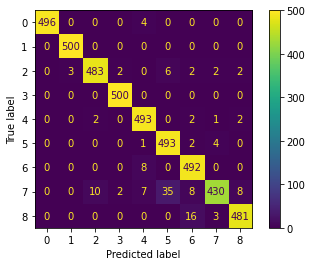

In [16]:
#LBL-8 построение матрицы ошибок, специфичности и чувствительности модели
import sklearn
r = sklearn.metrics.confusion_matrix(d_test.labels[:len(pred_1)], pred_1)
disp = ConfusionMatrixDisplay(confusion_matrix=r)
disp.plot()
plt.show()

In [14]:
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd
res = []
for l in range(9):
     prec,recall,_,_ = precision_recall_fscore_support(np.array(d_test.labels)==l,
                                                  np.array(pred_1)==l,
                                                  pos_label=True,average=None)
     res.append([l,recall[0],recall[1]])

pd.DataFrame(res,columns = ['class','sensitivity','specificity'], index=TISSUE_CLASSES)

,class,sensitivity,specificity
ADI,0,1.00000,0.992
BACK,1,0.99925,1.000
DEB,2,0.99700,0.966
LYM,3,0.99900,1.000
MUC,4,0.99500,0.986
MUS,5,0.98975,0.986
NORM,6,0.99250,0.984
STR,7,0.99750,0.860
TUM,8,0.99700,0.962


**Вывод графиков**

In [17]:
X_train, X_valid, y_train, y_valid = d_train_tiny.images, d_test_tiny.images, d_train_tiny.labels, d_test_tiny.labels 
model.train_with_hand_valid(X_train, y_train, X_valid, y_valid, 10)

train_with_hand_valid started
Epoch 1/10
 6/29 [=====>........................] - ETA: 7s - loss: 0.2215 - accuracy: 0.9323

29/29 [==============================] - ETA: 0s - loss: 0.1252 - accuracy: 0.9600
10 epochs have passed, the weights are preserved.

29/29 [==============================] - 29s 677ms/step - loss: 0.1252 - accuracy: 0.9600 - val_loss: 0.2039 - val_accuracy: 0.9556
Epoch 2/10
29/29 [==============================] - ETA: 0s - loss: 0.0904 - accuracy: 0.9711
Model is obtained with 0.8222222328186035 accuracy on validation. Weights saved.

29/29 [==============================] - 10s 358ms/step - loss: 0.0904 - accuracy: 0.9711 - val_loss: 0.7037 - val_accuracy: 0.8222
Epoch 3/10
29/29 [==============================] - 9s 326ms/step - loss: 0.1220 - accuracy: 0.9667 - val_loss: 0.2983 - val_accuracy: 0.9000
Epoch 4/10
29/29 [==============================] - 10s 332ms/step - loss: 0.0882 - accuracy: 0.9722 - val_loss: 0.6121 - val_accuracy: 0.8778
Epoch 5/10
29/29 [==============================] - 10s 334ms/step - loss: 0.0656 - accuracy: 0.9711 - val_loss: 0.4549 - val_accuracy: 0.900

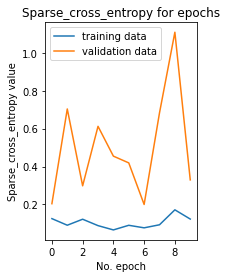

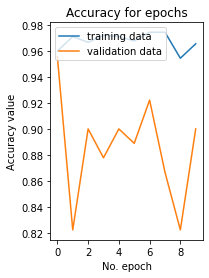

In [18]:
model.visualize()

Пример тестирования модели на части набора данных:

Пример тестирования модели на полном наборе данных:

In [15]:
model.load('best')
# evaluating model on full test dataset (may take time)
if TEST_ON_LARGE_DATASET:
    pred_2 = model.test_on_dataset(d_test)
    Metrics.print_all(d_test.labels, pred_2, 'test')

Downloading...
From: https://drive.google.com/uc?id=1-Pyky-liGa3CPsOK3nVfISDK7ZyOvoGI
To: /content/best.h5
100%|██████████| 197M/197M [00:00<00:00, 225MB/s]


  0%|          | 0/4500 [00:00<?, ?it/s]

metrics for test:
	 accuracy 0.9707:
	 balanced accuracy 0.9707:


Результат работы пайплайна обучения и тестирования выше тоже будет оцениваться. Поэтому не забудьте присылать на проверку ноутбук с выполнеными ячейками кода с демонстрациями метрик обучения, графиками и т.п. В этом пайплайне Вам необходимо продемонстрировать работу всех реализованных дополнений, улучшений и т.п.

<font color="red">
Настоятельно рекомендуется после получения пайплайна с полными результатами обучения экспортировать ноутбук в pdf (файл -> печать) и прислать этот pdf вместе с самим ноутбуком.
</font>

### Тестирование модели на других наборах данных

Ваша модель должна поддерживать тестирование на других наборах данных. Для удобства, Вам предоставляется набор данных test_tiny, который представляет собой малую часть (2% изображений) набора test. Ниже приведен фрагмент кода, который будет осуществлять тестирование для оценивания Вашей модели на дополнительных тестовых наборах данных.

<font color="red">
Прежде чем отсылать задание на проверку, убедитесь в работоспособности фрагмента кода ниже.
</font>

In [19]:
final_model = Model()
final_model.load('best')
d_test_tiny = Dataset('test_tiny')
pred = final_model.test_on_dataset(d_test_tiny)
Metrics.print_all(d_test_tiny.labels, pred, 'test-tiny')

Downloading...
From: https://drive.google.com/uc?id=1-Pyky-liGa3CPsOK3nVfISDK7ZyOvoGI
To: /content/best.h5
100%|██████████| 197M/197M [00:00<00:00, 245MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1JcDlKmFQ-ohdFVMQDINGY2EauuSGSVgv
To: /content/test_tiny.npz
100%|██████████| 10.6M/10.6M [00:00<00:00, 195MB/s]

Loading dataset test_tiny from npz.
Done. Dataset test_tiny consists of 90 images.


  0%|          | 0/90 [00:00<?, ?it/s]

metrics for test-tiny:
	 accuracy 0.9556:
	 balanced accuracy 0.9556:


Отмонтировать Google Drive.

In [ ]:
drive.flush_and_unmount()

---
# Дополнительные "полезности"

Ниже приведены примеры использования различных функций и библиотек, которые могут быть полезны при выполнении данного практического задания.

### Измерение времени работы кода

Измерять время работы какой-либо функции можно легко и непринужденно при помощи функции timeit из соответствующего модуля:

In [ ]:
import timeit

def factorial(n):
    res = 1
    for i in range(1, n + 1):
        res *= i
    return res


def f():
    return factorial(n=1000)

n_runs = 128
print(f'Function f is caluclated {n_runs} times in {timeit.timeit(f, number=n_runs)}s.')

### Scikit-learn

Для использования "классических" алгоритмов машинного обучения рекомендуется использовать библиотеку scikit-learn (https://scikit-learn.org/stable/). Пример классификации изображений цифр из набора данных MNIST при помощи классификатора SVM:

In [ ]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

# The digits dataset
digits = datasets.load_digits()

# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
_, axes = plt.subplots(2, 4)
images_and_labels = list(zip(digits.images, digits.target))
for ax, (image, label) in zip(axes[0, :], images_and_labels[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.001)

# Split data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False)

# We learn the digits on the first half of the digits
classifier.fit(X_train, y_train)

# Now predict the value of the digit on the second half:
predicted = classifier.predict(X_test)

images_and_predictions = list(zip(digits.images[n_samples // 2:], predicted))
for ax, (image, prediction) in zip(axes[1, :], images_and_predictions[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Prediction: %i' % prediction)

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(y_test, predicted)))
disp = metrics.plot_confusion_matrix(classifier, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print("Confusion matrix:\n%s" % disp.confusion_matrix)

plt.show()

### Scikit-image

Реализовывать различные операции для работы с изображениями можно как самостоятельно, работая с массивами numpy, так и используя специализированные библиотеки, например, scikit-image (https://scikit-image.org/). Ниже приведен пример использования Canny edge detector.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature


# Generate noisy image of a square
im = np.zeros((128, 128))
im[32:-32, 32:-32] = 1

im = ndi.rotate(im, 15, mode='constant')
im = ndi.gaussian_filter(im, 4)
im += 0.2 * np.random.random(im.shape)

# Compute the Canny filter for two values of sigma
edges1 = feature.canny(im)
edges2 = feature.canny(im, sigma=3)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title(r'Canny filter, $\sigma=3$', fontsize=20)

fig.tight_layout()

plt.show()

### Tensorflow 2

Для создания и обучения нейросетевых моделей можно использовать фреймворк глубокого обучения Tensorflow 2. Ниже приведен пример простейшей нейроной сети, использующейся для классификации изображений из набора данных MNIST.

In [ ]:
# Install TensorFlow

import tensorflow as tf

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)

model.evaluate(x_test,  y_test, verbose=2)

<font color="red">
Для эффективной работы с моделями глубокого обучения убедитесь в том, что в текущей среде Google Colab используется аппаратный ускоритель GPU или TPU. Для смены среды выберите "среда выполнения" -> "сменить среду выполнения".
</font>

Большое количество туториалов и примеров с кодом на Tensorflow 2 можно найти на официальном сайте https://www.tensorflow.org/tutorials?hl=ru. 

Также, Вам может понадобиться написать собственный генератор данных для Tensorflow 2. Скорее всего он будет достаточно простым, и его легко можно будет реализовать, используя официальную документацию TensorFlow 2. Но, на всякий случай (если не удлось сразу разобраться или хочется вникнуть в тему более глубоко), можете посмотреть следующий отличный туториал: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.

### Numba

В некоторых ситуациях, при ручных реализациях графовых алгоритмов, выполнение многократных вложенных циклов for в python можно существенно ускорить, используя JIT-компилятор Numba (https://numba.pydata.org/).
Примеры использования Numba в Google Colab можно найти тут:
1. https://colab.research.google.com/github/cbernet/maldives/blob/master/numba/numba_cuda.ipynb
2. https://colab.research.google.com/github/evaneschneider/parallel-programming/blob/master/COMPASS_gpu_intro.ipynb 

> Пожалуйста, если Вы решили использовать Numba для решения этого практического задания, еще раз подумайте, нужно ли это Вам, и есть ли возможность реализовать требуемую функциональность иным способом. Используйте Numba только при реальной необходимости.



### Работа с zip архивами в Google Drive

Запаковка и распаковка zip архивов может пригодиться при сохранении и загрузки Вашей модели. Ниже приведен фрагмент кода, иллюстрирующий помещение нескольких файлов в zip архив с последующим чтением файлов из него. Все действия с директориями, файлами и архивами должны осущетвляться с примонтированным Google Drive.


Создадим 2 изображения, поместим их в директорию tmp внутри PROJECT_DIR, запакуем директорию tmp в архив tmp.zip.

In [ ]:
PROJECT_DIR = "/dev/prak_nn_1/"
arr1 = np.random.rand(100, 100, 3) * 255
arr2 = np.random.rand(100, 100, 3) * 255

img1 = Image.fromarray(arr1.astype('uint8'))
img2 = Image.fromarray(arr2.astype('uint8'))

p = "/content/drive/MyDrive/" + PROJECT_DIR

if not (Path(p) / 'tmp').exists():
    (Path(p) / 'tmp').mkdir()

img1.save(str(Path(p) / 'tmp' / 'img1.png'))
img2.save(str(Path(p) / 'tmp' / 'img2.png'))

%cd $p
!zip -r "tmp.zip" "tmp"

Распакуем архив tmp.zip в директорию tmp2 в PROJECT_DIR. Теперь внутри директории tmp2 содержится директория tmp, внутри которой находятся 2 изображения.

In [ ]:
p = "/content/drive/MyDrive/" + PROJECT_DIR
%cd $p
!unzip -uq "tmp.zip" -d "tmp2"